In [1]:
# Run this cell first. Does all imports and function definitions

# Import python dependencies
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.special import ive, dawsn
import scipy.special as sp
from scipy import constants as const

# Set physical constants
u = const.atomic_mass
me = const.electron_mass
kB = const.Boltzmann
e = const.elementary_charge
epsilon_0 = const.epsilon_0
c = const.c

# Calculate the wavenumber components based on radar frequency and angle
def calculate_wavenumber_components(radar_frequency, theta_degrees):
    """
    Parameters:
    - radar_frequency (float): frequency of the radar wave [Hz].
    - theta_degrees (float): angle of wavenumber with respect to magnetic field [degrees].
    
    Returns:
    - k (float): Total wavenumber of the radar wave [rad/m].
    - k_parallel (float): Parallel component of the wavenumber [rad/m].
    - k_perpendicular (float): Perpendicular component of the wavenumber [rad/m].
    """
    lambda_wavelength = c/radar_frequency  # Get the wavelength of the radar wave
    theta = np.radians(theta_degrees) #Convert theta value from degrees to radians
    k = 2 * 2 * np.pi / lambda_wavelength #Calculate total wavenumber 
    k_parallel = k * np.cos(theta) #Break down k into the portion that is in the same direction of propogation
    k_perpendicular = k * np.sin(theta) #Break down k into the portion that is orthogonal to the parallel direction 
                                        #(the portion that is perpendicular to the direction of propogation)
    return k, k_parallel, k_perpendicular #Return the total wavenumber and it's components

# Calculate the thermal velocity of the species
def calculate_thermal_velocity(T, m):
    """
    Parameters:
    - kB (float): Boltzmann constant [J/K].
    - T (float): Temperature [Kelvin].
    - m (float): Mass [kg].

    Returns:
    - vth (float): Thermal velocity [m/s].
    """
    return np.sqrt( (2 * kB * T ) / m) #calculate the thermal velocity

# Calculates gyrofrequency
def calculate_cyclotron_frequency(Z, B, m):
    """
    Parameters:
    - Z (int): Charge state of the particle.
    - B (float): Magnetic field strength [T].
    - m (float): Mass of the particle [kg]

    Returns:
    - Oc(float): Cyclotron frequency [rad/s].
    """
    return (Z * e * B) / m #calculate the cyclotron frequency

# Calculates the average gyroradius based on thermal velocity
def calculate_average_gyroradius(vth, Oc):
    """
    Parameters:
    - vth (float): Thermal velocity [m/s].
    - Oc (float): Cyclotron frequency [rad/s].

    Returns:
    - rho (float): Average gyroradius [m].
    """
    return vth / (np.sqrt(2) * Oc) #calculate the gyroradius

# Calculate the debye length of the plasma
def calculate_debye_length(Te, ne):
    """
    Calculate the electron Debye length.

    Parameters:
    - Te (float): Electron temperature [Kelvin].
    - ne (float): Electron density [m^-3].

    Returns:
    - Debye length (float) [m].
    """
    return np.sqrt(epsilon_0 * kB * Te / (ne * e**2)) #calculate the debye length

# Calculate the incoherent scattering parameter. Determines if the plasma is in the collective or non-collective regime
def calculate_alpha(k, lambda_D):
    """
    Parameters:
    - k (float): Wavenumber of the radar wave [rad/m].
    - lambda_De (float): Electron Debye length [m].

    Returns:
    - alpha (float): the incoherent scattering parameter.
    """
    return 1 / (k * lambda_D) #calculate alpha

# The next three functions are found in Eqs. 41-43 from Skolar et al. Phyiscs of Plasmas (2025). For full derivation, please see the Froula 2011 Plasma Scattering Book
# Calculates the collisional term used for getting modified distribution and susceptibility
def calculate_collisional_term(nu, k_par, vth, k_perp, rho, n, omega, Oc):
    """
    Parameters:
    - nu (float): Collisional Frequency [Hz].
    - k_par (float): Parallel component of the wavenumber [rad/m].
    - vth (float): Thermal velocity [m/s].
    - k_perp (float): Perpendicular component of the wavenumber [rad/m].
    - rho (float): Average gyroradius [m].
    - n (int): Number of Bessel function summations to consider. As rule of thumb, 2000 is good for ions and 20 is good for electrons
    - omega (float): An array of doppler shifted frequency points [rad/s].
    - Oc (float): Cyclotron frequency [rad/s].

   Returns;
    - U (complex float): Collisional Term.
    """
    U = np.zeros_like(omega) + 1j * 0.0 #create an array of complex 0s the same size as the omega values array
    k_rho_sq = (k_perp ** 2) * (rho ** 2) #calculate the k_rho_sq constant
    
    for i in range(-n, n + 1): #iterate from -n to n + 1
        yn = (omega - i * Oc - 1j * nu) / (k_par * vth) #calculate the yn constant, using the current value of i 
                                                        #omega is adjusted by subtracting the current cyclotron frequency and the collisional damping
                                                        #omega is normalized by dividing by the parallel wavenumber and thermal velocity
        
        U += sp.ive(i, k_rho_sq) * (2 * sp.dawsn(yn) + 1j * np.sqrt(np.pi) * np.exp(-yn ** 2)) #accumulate the components
    U *= 1j * nu / (k_par * vth) #scale U by the collisional damping factor  
    return U

# Calculates the modified distribution function of the species. 
def calculate_modified_distribution(omega, k_par, k_perp, vth, n, rho, Oc, nu, U):
    """
    Parameters:
    - omega (float): An array of doppler shifted frequency points [rad/s].
    - k_par (float): Parallel component of the wavenumber [rad/m].
    - k_perp (float): Perpendicular component of the wavenumber [rad/m].
    - vth (float): Thermal velocity [m/s].
    - n (int): Number of Bessel function summations to consider. As rule of thumb, 2000 is good for ions and 20 is good for electrons
    - rho (float): Average gyroradius [m].
    - Oc (float): Cyclotron frequency [rad/s].
    - nu (float): Collisional Frequency [Hz].
    - U (complex float): Collisional Term.
    
   Returns;
    - M (float): Modified distribution function [Hz^-1].
    """
    M = np.zeros_like(omega) + 1j * 0.0
    k_rho_sq = (k_perp ** 2) * (rho ** 2)
    
    # Term involving |U|^2
    term_one = -(abs(U) ** 2) / (nu * (abs(1 + U) ** 2))
    
    # Prefactor involving k_parallel and vth
    term_two = 1 / (k_par * vth * (abs(1 + U) ** 2))
    
    # Summation term
    for i in range(-n, n + 1):
        yn = (omega - i * Oc - 1j * nu) / (k_par * vth)
        
        # Real part of the exponential term
        exp_re = np.real(np.exp(-yn**2))  
        
        # Imaginary part (Dawson function term)
        imag_da = 2*np.imag(dawsn(yn))  
        
        # Bessel function and exponential term
        bessel_term = ive(i, k_rho_sq)
        # Combine all terms in the summation
        M += bessel_term * (np.sqrt(np.pi) * exp_re + imag_da)
    
    # Combine all terms into M_s
    M_s = term_one + term_two * M
    return np.real(M_s) # Only taking real value at the end to get rid of small numerical errors that may keep a small imaginary part

# Calculates the susceptibility
def calculate_electric_susceptibility(omega, k_par, k_perp, vth, n, rho, Oc, nu, alpha, U, Te, Ts):
    """
    Parameters:
    - omega (float): An array of doppler shifted frequency points [rad/].
    - k_par (float): Parallel component of the wavenumber [rad/m].
    - k_perp (float): Perpendicular component of the wavenumber [rad/m].
    - vth (float): Thermal velocity [m/s].
    - n (int): Number of Bessel function summations to consider. As rule of thumb, 2000 is good for ions and 20 is good for electrons
    - rho (float): Average gyroradius [m].
    - Oc (float): Cyclotron frequency [rad/s].
    - nu (float): Collision frequency [Hz].
    - alpha (float): Incoherent scattering parameter.
    - U (float): Collisional term.
    - Te (float): Temperature of the electron [Kelvin].
    - Ts (float): Temperature of the species [Kelvin].

    Returns:
    - chi (complex float): Susceptibility
    """
    chi = np.zeros_like(omega) + 1j * 0.0 #create an array of complex 0s, the same size as the omega values array
    k_rho_sq = (k_perp ** 2) * (rho ** 2) #calculate the k_rho_sq constant
    term_one = (omega - 1j * nu) / (k_par * vth) #calculate the first term
    term_four = (alpha ** 2) / (1 + U) #calculate the fourth term
    term_five = Te / Ts #calculate the fifth term
    for i in range(-n, n + 1): #iterate from -n to n + 1
        yn = (omega - i * Oc - 1j * nu) / (k_par * vth) #calculate the yn constant, using the current value of i 
                                                        #omega is adjusted by subtracting the current cyclotron frequency and the collisional damping
                                                        #omega is normalized by dividing by the parallel wavenumber and thermal velocity 
        
        term_two = 2 * sp.dawsn(yn) #calculate the second term using the current value of yn
        term_three = 1j * np.sqrt(np.pi) * np.exp(-yn ** 2) #calculate the second term using the current value of yn
        chi += sp.ive(i, k_rho_sq) * (1 - term_one * (term_two + term_three)) #accumulate the terms
    return term_four * term_five * chi #return the remaining terms and the accumulated term

# Calculate the spectrum for one ion
def calcSpectra_1Ion(M_i, M_e, chi_i, chi_e):
    """
    Parameters:
    - M_i (float): An array representing the modified distribution for ions .
    - M_e (float): An array representing the modified distribution for electrons.
    - chi_i (complex float): An array representing the electric susceptibility for ions.
    - chi_e  (complex float): An array representing the electric susceptibility for electrons.
    Returns:
    - Spectrum (complex float): An array representing the incoherent scatter spectrum
    """
    epsilon = 1 + chi_e + chi_i # Dielectric function
    
    spectrum = 2*np.abs(1-chi_e/epsilon)**2*M_e+2*np.abs(chi_e/epsilon)**2*M_i #calculate the spectrum using ion and electron components
    return spectrum

# This is the full spectrum calculation that takes plasma parameter and radar inputs and outputs the incoherent scatter spectrum
# Does this for one ion species only
def fullSpectrumCalculation_1Ion(nui, nue, ne, mi, B, theta, Ti, Te, radar_frequency, omega):
    """
    Parameters:
    - nui (float): Ion collision frequency [Hz]
    - nue (float): Electron collision frequency [Hz]
    - ne (float): Electron or plasma density [m^-3]
    - mi (float): Ion mass [kg]
    - B (float): Magnetic field strength (T)
    - theta (float): Wavenumber of angle with respect to the magnetic field [degrees]
    - Ti (float): Ion temperature [K]
    - Te (float): Electron temperature [K]
    - radar_frequency (float): Radar frequency [Hz]
    - omega (float): Array of doppler-shifted frequency values. [rad/s] Set this array to be where you want to look at for your spectrum. 
    Returns:
    - Spectrum (float): An array representing the incoherent scatter spectrum [Hz^-1 m^-3]
    """

    # Calculate wavenumber
    k_total, k_parallel, k_perpendicular = calculate_wavenumber_components(radar_frequency, theta)
    
    # Calculate thermal velocities, gyrofrequency, gyroradius, Debye length, and incoherent parameter
    vth_i = calculate_thermal_velocity(Ti, mi)
    vth_e = calculate_thermal_velocity(Te, me)
    Oc_i = calculate_cyclotron_frequency(1, B, mi)
    Oc_e = calculate_cyclotron_frequency(1, B, me)
    rho_i = calculate_average_gyroradius(vth_i, Oc_i)
    rho_e = calculate_average_gyroradius(vth_e, Oc_e)
    lambda_D = calculate_debye_length(Te, ne)
    alpha = calculate_alpha(k_total, lambda_D)

    U_i = calculate_collisional_term(nui, k_parallel, vth_i, k_perpendicular, rho_i, 2000, omega, Oc_i)
    U_e = calculate_collisional_term(nue, k_parallel, vth_e, k_perpendicular, rho_e, 20, omega, Oc_e)
    M_i = calculate_modified_distribution(omega, k_parallel, k_perpendicular, vth_i, 2000, rho_i, Oc_i, nui, U_i)
    M_e = calculate_modified_distribution(omega, k_parallel, k_perpendicular, vth_e, 20, rho_e, Oc_e, nue, U_e)
    chi_i = calculate_electric_susceptibility(omega, k_parallel, k_perpendicular, vth_i, 2000, rho_i, Oc_i, nui, alpha, U_i, Te, Ti)
    chi_e = calculate_electric_susceptibility(omega, k_parallel, k_perpendicular, vth_e, 20, rho_e, Oc_e, nue, alpha, U_e, Te, Te)
    return calcSpectra_1Ion(M_i, M_e, chi_i, chi_e)*ne

# This is the full spectrum calculation that takes plasma parameter and radar inputs and outputs the incoherent scatter spectrum
# This is for multiple ion species
def fullSpectrumCalculation_MultiIon(nui, nue, nFrac, ne, mi, B, theta, Ti, Te, radar_frequency, omega):
    """
    Parameters:
    - nui (float array): Ion collision frequency [Hz]
    - nue (float): Electron collision frequency [Hz]
    - nFrac (float array): The fractional amount of each ion species with respect to whole plasma density. Summation of this array should equal 1
    - ne (float): Electron or plasma density [m^-3]
    - mi (float array): Ion mass [kg]
    - B (float): Magnetic field strength (T)
    - theta (float): Wavenumber of angle with respect to the magnetic field [degrees]
    - Ti (float array): Ion temperature [K]
    - Te (float): Electron temperature [K]
    - radar_frequency (float): Radar frequency [Hz]
    - omega (float): Array of doppler-shifted frequency values. [rad/s] Set this array to be where you want to look at for your spectrum. 
    Returns:
    - Spectrum (float): An array representing the incoherent scatter spectrum [Hz^-1 m^-3]
    """

    # Calculate wavenumber
    k_total, k_parallel, k_perpendicular = calculate_wavenumber_components(radar_frequency, theta)
    
    # Calculate thermal velocities, gyrofrequency, gyroradius, Debye length, and incoherent parameter
    # In these next few sets of lines, all the ion terms become arrays
    vth_i = calculate_thermal_velocity(Ti, mi)
    vth_e = calculate_thermal_velocity(Te, me)
    Oc_i = calculate_cyclotron_frequency(1, B, mi)
    Oc_e = calculate_cyclotron_frequency(1, B, me)
    rho_i = calculate_average_gyroradius(vth_i, Oc_i)
    rho_e = calculate_average_gyroradius(vth_e, Oc_e)
    lambda_D = calculate_debye_length(Te, ne)
    alpha = calculate_alpha(k_total, lambda_D)

    U_e = calculate_collisional_term(nue, k_parallel, vth_e, k_perpendicular, rho_e, 20, omega, Oc_e)
    M_e = calculate_modified_distribution(omega, k_parallel, k_perpendicular, vth_e, 20, rho_e, Oc_e, nue, U_e)
    chi_e = calculate_electric_susceptibility(omega, k_parallel, k_perpendicular, vth_e, 20, rho_e, Oc_e, nue, alpha, U_e, Te, Te)

    # Calculate electron part of dielectric function
    epsilon = 1 + chi_e

    # Get the total summation of the ion modified distribution functions
    M_i_total = np.zeros_like(omega) # Should have same array size as omega
    # Iterate through the ion species
    for i in range(0,len(nFrac)):
        U_i = calculate_collisional_term(nui[i], k_parallel, vth_i[i], k_perpendicular, rho_i[i], 2000, omega, Oc_i[i])
        M_i = nFrac[i]*calculate_modified_distribution(omega, k_parallel, k_perpendicular, vth_i[i], 2000, rho_i[i], Oc_i[i], nui[i], U_i)    
        chi_i = nFrac[i]*calculate_electric_susceptibility(omega, k_parallel, k_perpendicular, vth_i[i], 2000, rho_i[i], Oc_i[i], nui[i], alpha, U_i, Te, Ti[i])

        # Add to dielectric function and total distribution function
        epsilon += chi_i
        M_i_total += M_i

    # Calculate the incoherent scatter spectrum
    return (2*np.abs(1-chi_e/epsilon)**2*M_e + 2*np.abs(chi_e/epsilon)**2*M_i_total)*ne

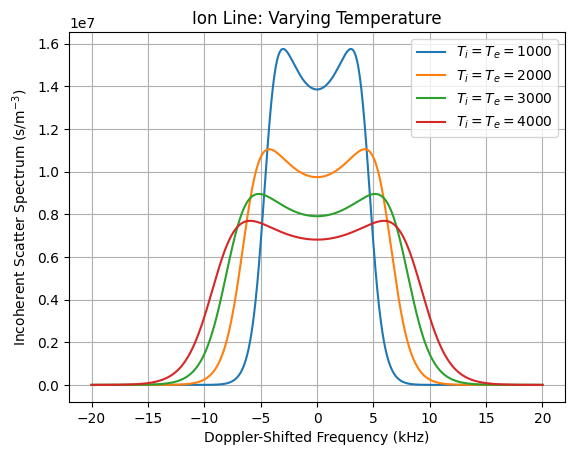

In [ ]:
# Example plot examining change of temperature. Have Ti = Te
# Calculating ion line spectrum for only one ion species

# Set plasma and radar parameters
nui = 1  # Ion collision frequency [Hz]
nue = 1  # Electron collision frequency [Hz]
ne = 3e11  # Ion and electron densities [m^-3]
mi = 16*u  # Ion mass (atomic oxygen) [kg]
B = 3.6e-5  # Magnetic field strength [T]
theta = 0.  # Aspect angle [degrees]
Ti = Te = np.array([1,2,3,4])*1000   # An array of ion and electron temperatures [K]
radar_frequency = 449.3e6  # Radar transmit frequency [Hz]

# Make the frequency mesh. Chage as needed for what features you want to look at
omega = np.linspace(-20e3,20e3,num=1000)*2*np.pi   # [rad/s]

# Iterate through all different temperature cases
for i in range(len(Ti)):
    # Calculate the spectrum for a one ion species
    spectrum = fullSpectrumCalculation_1Ion(nui, nue, ne, mi, B, theta, Ti[i], Te[i], radar_frequency, omega)

    # Plot it. Note that we are converting the angular frequency back to regular frequency in kHz here
    plt.plot(omega/2/np.pi/1000, spectrum,label='$T_i=T_e=' + str(Ti[i]) + '$')

# Make plot look nice
plt.grid()
plt.xlabel('Doppler-Shifted Frequency (kHz)')
plt.ylabel('Incoherent Scatter Spectrum (s/m$^{-3}$)')
plt.legend()
plt.title('Ion Line: Varying Temperature');

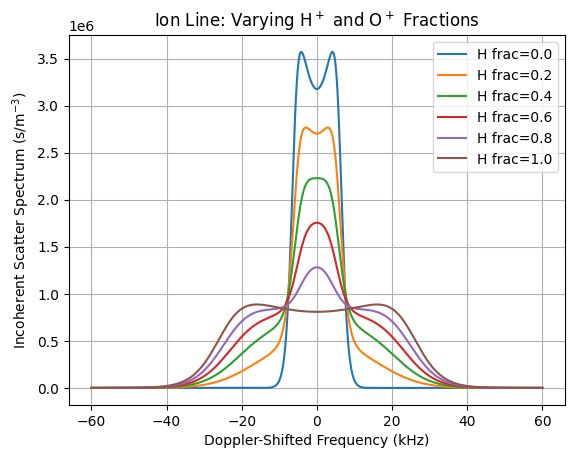

In [3]:
# Example of how to use the multi-ion species (assumes all ions are positively charged) spectrum calculator
# Shows a plot of an oxygen-hydrogen-electron plasma with different percentages of H+ population

# Set plasma and radar parameters. Note how that now all of the ion parameters are numpy arrays. 
nui = np.array([1,1])  # Ion collision frequency [Hz]
nue = 1  # Electron collision frequency [Hz]
ne = 1e11   # Plasma density [m^-3]
mi = np.array([16,1])*u  # Ion mass [kg]. First species is oxygen, second is hydrogen
B = 3.6e-5   # Magnetic field strength [T]
Te = 2000.  # Electron temperature [K]
Ti = np.array([2000., 2000.]) # Ion temperature [K]
radar_frequency = 449.3e6   # Radar transmit frequency [Hz]

H_frac = np.array([0,.2,.4,.6,.8,1])
O_frac  = 1 - H_frac

# Make the frequency mesh. Chage as needed for what features you want to look at
omega = np.linspace(-60e3,60e3,num=1000)*2*np.pi

# Iterate through percent fraction cases
for i in range(len(H_frac)):
    # Calculate wavenumber
    spectrum = fullSpectrumCalculation_MultiIon(nui, nue, np.array([O_frac[i],H_frac[i]]), ne, mi, B, theta, Ti, Te, radar_frequency, omega)

    # Plot it. Note that we are converting the angular frequency back to regular frequency in kHz here
    plt.plot(omega/2/np.pi/1000, spectrum,label='H frac=' + str(H_frac[i]))

# Make plot look nice
plt.grid()
plt.xlabel('Doppler-Shifted Frequency (kHz)')
plt.ylabel('Incoherent Scatter Spectrum (s/m$^{-3}$)')
plt.legend()
plt.title('Ion Line: Varying H$^+$ and O$^+$ Fractions');

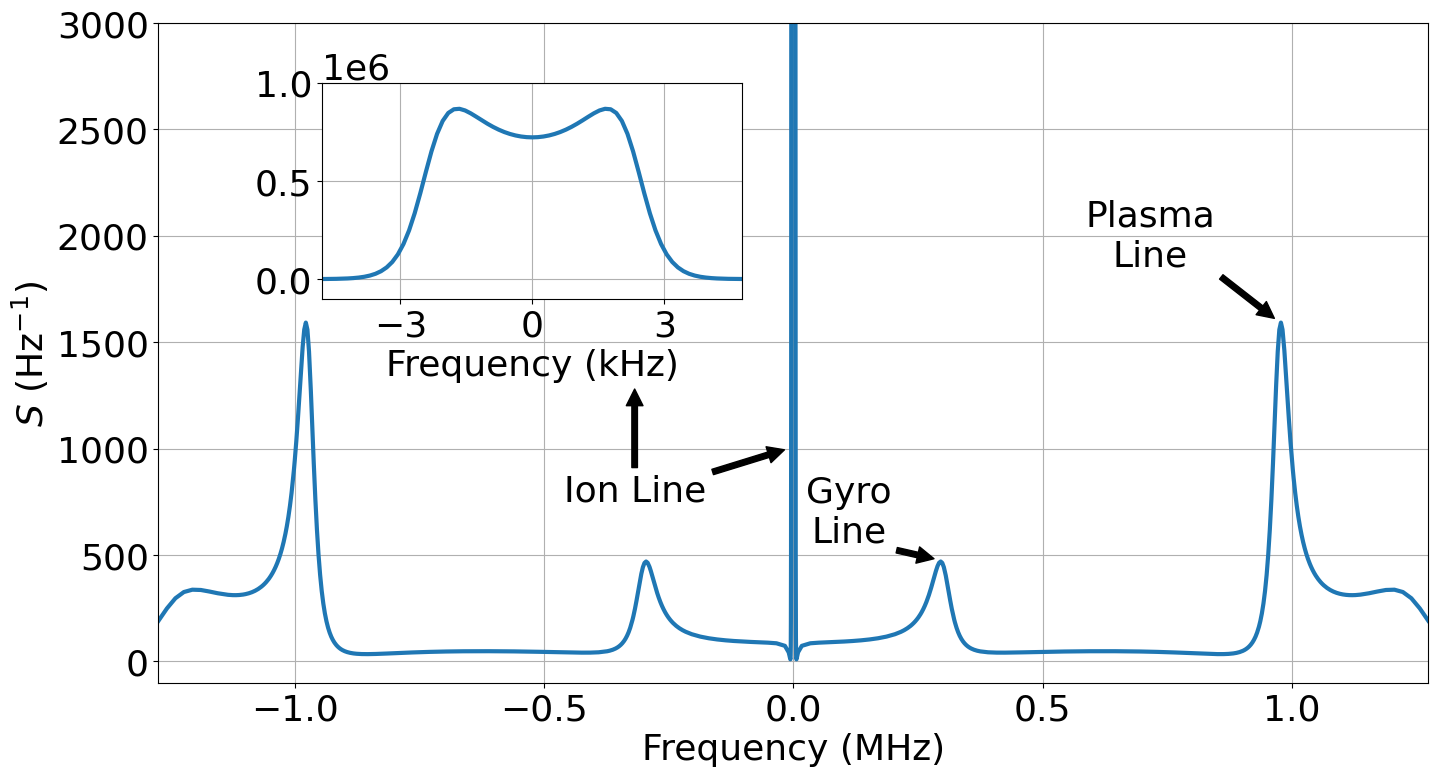

In [4]:
# Example plot of a full spectrum looking at ion, gyro, and plasma lines
# Mimics Fig 6a from Skolar et al. Physics of Plasmas (2025)

# Set plasma and radar parameters
nui = 10.  # Ion collision frequency [Hz]
nue = 100.  # Electron collision frequency [Hz]
ne = 1.e10  # Ion and electron densities [m^-3]
mi = 16*u  # Ion mass (atomic oxygen) [kg]
B = 2.e-5  # Magnetic field strength [T]
theta = 60.  # Aspect angle [degrees]
Ti = 1000.  # Ion temperature [K]
Te = 1200.   # Electron temperature [K]
radar_frequency = 230.e6  # Radar transmit frequency [Hz]

# Making a set of meshes for the full spectrum. We need to have higher resolution near some of the resonances
# These were chosen purely by looking at where there needed to be more resolution to see the features. Could be made smarter based on a priori knowledge of resonant frequencies
omega_full = np.linspace(-8e6,8e6,151)
omega_ion = np.linspace(-6e4,6e4,151)
omega_gyro = np.linspace(1856000-5e5,1856000+5e5,51)
omega_plasma= np.linspace(6143200-1e6,6143200+1e6,101)
omega = np.unique(np.concatenate((omega_ion, omega_full,omega_gyro,-omega_gyro,omega_plasma,-omega_plasma)))
freq = omega/2/np.pi

# Calculate the full spectrum
spectrum = fullSpectrumCalculation_1Ion(nui, nue, ne, mi, B, theta, Ti, Te, radar_frequency, omega)

# Make a nice figure
font = {'size'   : 26}
mpl.rc('font', **font)
fig = plt.figure(1, figsize=(14,8))
gs = gridspec.GridSpec(1,1)
gs.update(left=0.083 , right=.99, bottom=.12, top=.945, wspace=0.15, hspace=.015)
fig.patch.set_facecolor('white')
ax = plt.subplot(gs[0])

# Plot it. Note that we are converting the angular frequency back to regular frequency in MHz here
ax.plot(freq/1e6, spectrum,linewidth=3)

# Make zoomed in ion line plot
sub_ax = plt.axes([.2, .6, .3, .27])
sub_ax.plot(freq/1000, spectrum,linewidth=3)
sub_ax.set_xlim(-30/2/np.pi,30/2/np.pi)
sub_ax.set_ylim(-1e-5*ne,1e-4*ne)
sub_ax.set_yticks([0,5e-5*ne,1e-4*ne])
sub_ax.set_xticks([-3,0,3])
sub_ax.set_xlabel('Frequency (kHz)')
sub_ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
sub_ax.grid()

# Make plot look nice
ax.set_ylim(-1e-8*ne, 3e-7*ne)
ax.set_xlim(np.min(freq)/1e6,np.max(freq)/1e6)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('$S$ (Hz$^{-1}$)')
ax.grid()

# Annotate plot
arrowStyle = dict(facecolor='black', shrink=0.05)
ax.annotate('Ion Line', xy=(-.06/2/np.pi,1e-7*ne), xytext=(-2/2/np.pi,.8e-7*ne), ha='center',va='center',arrowprops=arrowStyle)
ax.annotate('', xy=(-2/2/np.pi,1.3e-7*ne), xytext=(-2/2/np.pi,.89e-7*ne), ha='center',va='center',arrowprops=arrowStyle)
ax.annotate('Gyro\nLine', xy=(1.8/2/np.pi,.48e-7*ne), xytext=(.7/2/np.pi,.7e-7*ne), ha='center',va='center',arrowprops=arrowStyle)
ax.annotate('Plasma\nLine', xy=(6.1/2/np.pi,1.6e-7*ne), xytext=(4.5/2/np.pi,2e-7*ne), ha='center',va='center',arrowprops=arrowStyle);